# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes


config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,    
        'dt_type': 'vanilla', #'SDT', 'vanilla'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        'categorical_indices': [],
        'random_parameters_distribution': True, ##MAKEPATH DIFFERENT FILES
        'max_distributions_per_class': 0, # None; 0; int >= 1        
        
        'dt_type_train': 'vanilla', # (None, 'vanilla', 'SDT')
        'maximum_depth_train': 4, #None or int
        'decision_sparsity_train': 1, #None or int
        
        'function_generation_type': 'distribtion_trained',# 'make_classification_distribution', 'make_classification_distribution_trained', 'distribtion', 'distribtion_trained', 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        #'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
        
        'number_of_lambda_weights': None,
        
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 8888,
    },     
    
    'i_net': {
        'dense_layers': [1024, 1024, 256, 2048, 2048],#[1024, 1024, 256, 2048, 2048],
        'convolution_layers': None,
        'lstm_layers': None,
        'dropout': [0.3, 0.3, 0.3, 0.3, 0.3],#[0.3, 0.3, 0.3, 0.3, 0.3],
        'additional_hidden': False,
        
        'optimizer': 'adam', #adam
        'learning_rate': 0.0001,
        'loss': 'binary_crossentropy', #mse; binary_crossentropy; 'binary_accuracy'
        'metrics': ['soft_binary_crossentropy', 'binary_accuracy'], #soft_ or _penalized
        
        'epochs': 500, 
        'early_stopping': True,
        'batch_size': 256,

        'interpretation_dataset_size': 8888,
                
        'test_size': 5, #Float for fraction, Int for number 0
        'evaluate_distribution': True,
        'force_evaluate_real_world': False,
        
        'function_representation_type': 3, # 1=standard representation; 2=sparse representation with classification for variables; 3=softmax to select classes (n top probabilities)
        'normalize_lambda_nets': False,

        'optimize_decision_function': True, #False
        'function_value_loss': True, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2,3) #3=autoencoder dimensionality reduction
        
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 60,
    },    
    
    'evaluation': {   
        #'inet_holdout_seed_evaluation': False,
            
        'random_evaluation_dataset_size': 10000, 
        'random_evaluation_dataset_distribution': 'uniform', 
        
        'per_network_optimization_dataset_size': 5000,

        #'sklearn_dt_benchmark': False,
        #'sdt_benchmark': False,
        
        'different_eval_data': False,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'make_classification',
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise_injected_level': 0, 
            'eval_data_noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_number_of_trained_lambda_nets': 100,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 100,
            
        }
        
    },    
    
    'computation':{
        'load_model': False,
        'n_jobs': 20,
        'use_gpu': False,
        'gpu_numbers': '2',
        'RANDOM_SEED': 42,   
        'verbosity': 0
    }
}


## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

from itertools import product       
from tqdm.notebook import tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import shutil

from copy import deepcopy
import math
import random 


import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score, log_loss
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

#import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output

from prettytable import PrettyTable


In [4]:
tf.__version__

'2.5.2'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################

config['i_net']['data_reshape_version'] = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
config['function_family']['decision_sparsity'] = config['function_family']['decision_sparsity'] if config['function_family']['decision_sparsity'] != -1 else config['data']['number_of_variables'] 

#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)
np.set_printoptions(suppress=True)



In [6]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
from utilities.DecisionTree_BASIC import *

#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
config['function_family']['basic_function_representation_length'] = get_number_of_function_parameters(dt_type, maximum_depth, number_of_variables, num_classes)
config['function_family']['function_representation_length'] = ( 
       #((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes  if function_representation_type == 1 and dt_type == 'SDT'
       (2 ** maximum_depth - 1) * (number_of_variables + 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 1 and dt_type == 'SDT'
  else (2 ** maximum_depth - 1) * decision_sparsity + (2 ** maximum_depth - 1) + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) * num_classes if function_representation_type == 2 and dt_type == 'SDT'
  else ((2 ** maximum_depth - 1) * decision_sparsity) * 2 + (2 ** maximum_depth)  if function_representation_type == 1 and dt_type == 'vanilla'
  else (2 ** maximum_depth - 1) * decision_sparsity + ((2 ** maximum_depth - 1)  * decision_sparsity * number_of_variables) + (2 ** maximum_depth) if function_representation_type == 2 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth)  if function_representation_type == 3 and dt_type == 'vanilla'
  else ((2 ** maximum_depth - 1) * number_of_variables * 2) + (2 ** maximum_depth - 1) + (2 ** maximum_depth) * num_classes if function_representation_type == 3 and dt_type == 'SDT'
  else None
                                                            )
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)
#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='interpretation_net'))

create_folders_inet(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [8]:
print(path_identifier_interpretation_net)

print(path_identifier_lambda_net_data)


lNetSize5000_numLNets8888_var10_class2_distribtion_trained_xMax1_xMin0_xDistuniform_randParamDist_maxDistClass0_depth4_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42/inet_dense1024-1024-256-2048-2048_drop0.3-0.3-0.3-0.3-0.3e500b256_adam_funcRep3_reshapeNone
lNetSize5000_numLNets8888_var10_class2_distribtion_trained_xMax1_xMin0_xDistuniform_randParamDist_maxDistClass0_depth4_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(config, no_noise=False, n_jobs=1):
    
    #def generate_lambda_net()
    
    #if psutil.virtual_memory().percent > 80:
        #raise SystemExit("Out of RAM!")
    
    if no_noise==True:
        config['noise_injected_level'] = 0
    path_dict = generate_paths(config, path_type='interpretation_net')        
        
    directory = './data/weights/' + 'weights_' + path_dict['path_identifier_lambda_net_data'] + '/'
    path_network_parameters = directory + 'weights' + '.txt'
    #path_X_data = directory + 'X_test_lambda.txt'
    #path_y_data = directory + 'y_test_lambda.txt'        
    path_distribution_parameters = directory + '/' + 'distribution_parameters' + '.txt'
    
    network_parameters = pd.read_csv(path_network_parameters, sep=",", header=None)
    network_parameters = network_parameters.sort_values(by=0)
    
    try:
        distribution_parameters = pd.read_csv(path_distribution_parameters, sep=",", header=None)
        distribution_parameters = distribution_parameters.sort_values(by=0)
    except:
        distribution_parameters = pd.DataFrame([None] * network_parameters.shape[0])
    
    if no_noise == False:
        network_parameters = network_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        distribution_parameters = distribution_parameters.sample(n=config['i_net']['interpretation_dataset_size'], random_state=config['computation']['RANDOM_SEED'])
        
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky

    lambda_nets = parallel(delayed(LambdaNet)(network_parameters_row, 
                                              distribution_parameters_row,
                                              #X_test_lambda_row, 
                                              #y_test_lambda_row, 
                                              config) for network_parameters_row, distribution_parameters_row in zip(network_parameters.values, distribution_parameters.values))        
    del parallel
    
    base_model = generate_base_model(config)  
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise_injected_level'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_level']
    config_eval['data']['noise_injected_type'] = config['evaluation']['eval_data_description']['eval_data_noise_injected_type'] 
    config_eval['lambda_net']['number_of_trained_lambda_nets'] = config['evaluation']['eval_data_description']['eval_data_number_of_trained_lambda_nets']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    

    lambda_net_dataset_train_with_valid = load_lambda_nets(config_train, n_jobs=n_jobs)
    lambda_net_dataset_eval = load_lambda_nets(config_eval, n_jobs=n_jobs)

    if test_size > 0:
        _, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)   
    else:
        lambda_net_dataset_test = None
    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)   

        
else:
    lambda_net_dataset = load_lambda_nets(config, n_jobs=n_jobs)

    if test_size > 0:
        lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    
    else:
        lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset, test_split=0.1)    
        lambda_net_dataset_test = None

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:   12.8s
[Parallel(n_jobs=20)]: Done 570 tasks      | elapsed:   14.0s
[Parallel(n_jobs=20)]: Done 3672 tasks      | elapsed:   16.6s
[Parallel(n_jobs=20)]: Done 8280 tasks      | elapsed:   20.4s
[Parallel(n_jobs=20)]: Done 8888 out of 8888 | elapsed:   20.9s finished


## Data Inspection

In [12]:
print(lambda_net_dataset_train.shape)
print(lambda_net_dataset_valid.shape)
if test_size > 0:
    print(lambda_net_dataset_test.shape)

(7994, 1561)
(889, 1561)
(5, 1561)


In [13]:
lambda_net_dataset_valid.as_pandas(config).head()

,index,seed,feat0,feat1,feat2,feat3,feat4,feat5,feat6,split0,split1,split2,split3,split4,split5,split6,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,wb_0,wb_1,wb_2,wb_3,wb_4,wb_5,wb_6,wb_7,wb_8,wb_9,wb_10,wb_11,wb_12,wb_13,wb_14,wb_15,wb_16,wb_17,wb_18,wb_19,wb_20,wb_21,wb_22,wb_23,wb_24,wb_25,wb_26,wb_27,wb_28,wb_29,wb_30,wb_31,wb_32,wb_33,wb_34,wb_35,wb_36,wb_37,wb_38,wb_39,wb_40,wb_41,wb_42,wb_43,wb_44,wb_45,wb_46,wb_47,wb_48,wb_49,wb_50,wb_51,wb_52,wb_53,wb_54,wb_55,wb_56,wb_57,wb_58,wb_59,wb_60,wb_61,wb_62,wb_63,wb_64,wb_65,wb_66,wb_67,wb_68,wb_69,wb_70,wb_71,wb_72,wb_73,wb_74,wb_75,...,wb_1437,wb_1438,wb_1439,wb_1440,wb_1441,wb_1442,wb_1443,wb_1444,wb_1445,wb_1446,wb_1447,wb_1448,wb_1449,wb_1450,wb_1451,wb_1452,wb_1453,wb_1454,wb_1455,wb_1456,wb_1457,wb_1458,wb_1459,wb_1460,wb_1461,wb_1462,wb_1463,wb_1464,wb_1465,wb_1466,wb_1467,wb_1468,wb_1469,wb_1470,wb_1471,wb_1472,wb_1473,wb_1474,wb_1475,wb_1476,wb_1477,wb_1478,wb_1479,wb_1480,wb_1481,wb_1482,wb_1483,wb_1484,wb_1485,wb_1486,wb_1487,wb_1488,wb_1489,wb_1490,wb_1491,wb_1492,wb_1493,wb_1494,wb_1495,wb_1496,wb_1497,wb_1498,wb_1499,wb_1500,wb_1501,wb_1502,wb_1503,wb_1504,wb_1505,wb_1506,wb_1507,wb_1508,wb_1509,wb_1510,wb_1511,wb_1512,wb_1513,wb_1514,wb_1515,wb_1516,wb_1517,wb_1518,wb_1519,wb_1520,wb_1521,wb_1522,wb_1523,wb_1524,wb_1525,wb_1526,wb_1527,wb_1528,wb_1529,wb_1530,wb_1531,wb_1532,wb_1533,wb_1534,wb_1535,wb_1536
5193,5193.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.410,-0.402,0.414,-0.487,-0.453,0.447,0.455,-0.461,-0.441,-0.387,0.462,-0.336,-0.457,-0.358,0.520,0.107,0.472,-0.299,-0.399,-0.334,-0.441,-0.409,0.452,0.419,0.513,0.415,-0.396,0.447,-0.455,0.513,-0.082,0.463,0.187,0.405,-0.342,0.052,-0.331,0.483,0.431,-0.486,0.422,0.075,0.502,0.515,0.153,0.097,0.448,-0.472,0.097,-0.477,0.536,-0.128,-0.215,-0.109,-0.385,0.418,0.393,-0.418,-0.201,0.518,-0.398,0.133,-0.463,0.193,0.392,-0.445,0.409,0.421,-0.329,-0.404,-0.404,0.555,0.409,-0.421,-0.406,-0.435,...,0.591,-0.085,0.615,0.194,0.465,-0.641,0.053,-0.545,0.607,0.735,-0.588,0.513,0.080,0.697,0.593,0.145,0.096,0.580,-0.723,0.102,-0.765,0.508,-0.133,-0.154,-0.113,-0.383,0.490,0.435,-0.761,-0.129,0.767,-0.619,0.141,-0.726,0.200,0.410,-0.851,0.390,0.469,-0.390,-0.829,-0.545,0.958,0.580,-0.641,-0.571,-0.633,-0.649,-0.490,0.599,-0.145,-0.607,-0.531,-0.603,0.649,0.379,-0.040,-0.727,0.394,-0.531,-0.471,0.690,-0.206,-0.082,0.348,0.658,0.468,-0.413,0.391,0.342,-0.630,-0.647,-0.782,-0.496,-0.891,0.466,0.543,0.108,0.105,-0.868,-0.657,0.067,-0.634,-0.006,0.550,-0.718,-0.796,-0.678,0.653,0.063,0.149,0.474,0.609,0.351,-0.541,-0.823,0.718,0.429,0.489,-0.254
5366,5366.000,42,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.218,0.298,0.376,-0.390,-0.380,0.366,0.397,-0.136,-0.176,-0.187,0.475,-0.112,-0.227,-0.282,0.084,0.379,0.323,-0.326,0.298,-0.338,-0.326,-0.216,0.305,0.306,0.448,0.338,-0.080,0.407,-0.296,0.353,-0.183,0.416,0.156,0.341,-0.206,0.041,-0.110,0.458,0.328,-0.340,0.359,0.068,0.446,0.449,0.450,0.113,0.406,-0.319,0.380,-0.406,0.432,-0.128,-0.330,-0.109,-0.207,0.403,0.314,-0.235,-0.374,0.444,-0.203,0.447,-0.332,0.151,0.331,-0.128,0.323,-0.130,-0.443,-0.104,-0.203,0.453,0.360,-0.275,-0.225,-0.244,...,0.861,-0.886,1.012,0.167,0.711,-0.786,0.050,-0.787,1.207,1.008,-1.106,0.771,0.071,1.315,1.089,1.164,0.119,0.971,-0.916,0.869,-1.489,1.172,-0.133,-1.376,-0.113,-0.753,0.925,0.870,-0.941,-1.301,1.114,-0.830,1.317,-0.886,0.168,0.822,-0.133,0.805,-1.064,-1.382,-0.107,-0.789,0.980,0.785,-0.785,-0.709,-0.610,-0.913,-0.657,1.246,-0.145,-0.794,-0.757,-0.111,1.123,0.756,-0.042,-0.967,0.802,-0.551,-0.782,0.840,-1.141,-0.767,0.627,0.976,0.863,-0.790,0.904,0.738,-1.040,-1.110,-0.203,-0.854,-0.106,0.858,1.058,0.097,1.132,-1.190,-0.072,0.062,-1.030,-0.883,0.970,0.799,-0.203,-1.563,1.020,0.076,0.138,0.950,1.347,-0.451,-0.635,-1.272,0.786,-0.678,0.821,-0.398
202,202.000,42,0.000,0

In [14]:
lambda_net_dataset_train.distribution_dict_list_list[11]

[{'beta': {'class_0': {'a': 2.0155936981563585, 'b': 5.827459787587756},
   'class_1': {'a': 2.0155936981563585, 'b': 5.827459787587756}}},
 {'uniform': {'class_0': {'low': 0.0890123011653193,
    'high': 0.7200206022832023},
   'class_1': {'low': 0.0890123011653193, 'high': 0.7200206022832023}}},
 {'normal': {'class_0': {'loc': 0.4018920417368597,
    'scale': 1.1685621877481862},
   'class_1': {'loc': 0.4018920417368597, 'scale': 1.1685621877481862}}},
 {'binomial': {'class_0': {'n': 4725.537759388319, 'p': 0.5940936794748911},
   'class_1': {'n': 4725.537759388319, 'p': 0.5940936794748911}}},
 {'poisson': {'class_0': {'lam': 1.069644416624142},
   'class_1': {'lam': 1.069644416624142}}},
 {'binomial': {'class_0': {'n': 5088.375582451124, 'p': 0.5590951752832152},
   'class_1': {'n': 5088.375582451124, 'p': 0.5590951752832152}}},
 {'exponential': {'class_0': {'scale': 0.4412723350093533},
   'class_1': {'scale': 0.4412723350093533}}},
 {'poisson': {'class_0': {'lam': 0.96309394860904

In [15]:
#lambda_net_dataset_train.distribution_dict_list_list[12]

In [16]:
generate_dataset_from_distributions(distribution_list=None, 
                                    number_of_variables=config['data']['number_of_variables'], 
                                    number_of_samples=config['evaluation']['random_evaluation_dataset_size'], 
                                    distributions_per_class = config['data']['max_distributions_per_class'], 
                                    seed = 42, 
                                    flip_percentage=0, 
                                    random_parameters=None, 
                                    distribution_dict_list=lambda_net_dataset_train.distribution_dict_list_list[12])[0].shape
   

(10000, 10)

## Interpretation Network Training

In [17]:
#%load_ext tensorboard
#%tensorboard --logdir data/logging/ --port=8811

In [18]:
#%load_ext autoreload
#%autoreload 2

In [19]:
((X_valid, y_valid), 
 (X_test, y_test),
 
 history,
 loss_function,
 metrics,
 
 model,
 encoder_model) = interpretation_net_training(
                                      lambda_net_dataset_train, 
                                      lambda_net_dataset_valid, 
                                      lambda_net_dataset_test,
                                      config,
                                      #callback_names=['tensorboard'] #plot_losses
                                     )



----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
(7994, 1)
(7994, 1537)
(7994, 22)


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:    6.2s
[Parallel(n_jobs=20)]: Done 472 tasks      | elapsed:   10.3s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   15.8s
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed:   22.5s
[Parallel(n_jobs=20)]: Done 1528 tasks      | elapsed:   30.2s
[Parallel(n_jobs=20)]: Done 2008 tasks      | elapsed:   39.1s
[Parallel(n_jobs=20)]: Done 2552 tasks      | elapsed:   49.3s
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed:  1.0min
[Parallel(n_jobs=20)]: Done 3832 tasks      | elapsed:  1.2min
[Parallel(n_jobs=20)]: Done 4568 tasks      | elapsed:  1.4min
[Parallel(n_jobs=20)]: Done 5368 tasks      | elapsed:  1.7min
[Parallel(n_jobs=20)]: Done 6232 tasks      | elapsed:  2.0min
[Parallel(n_jobs=20)]: Done 7160 tasks      | elapsed:  2.2min
[Parallel(n_jobs=20)]: Done 7994 out of 7994 

random_evaluation_dataset_array_train.shape (7994, 10000, 10)
random_evaluation_dataset_flat_array_train.shape (7994, 100000)


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:    4.7s
[Parallel(n_jobs=20)]: Done 472 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   14.2s
[Parallel(n_jobs=20)]: Done 889 out of 889 | elapsed:   16.4s finished


random_evaluation_dataset_array_valid.shape (889, 10000, 10)
random_evaluation_dataset_flat_array_valid.shape (889, 100000)
Epoch 1/500
32/32 - 101s - loss: 0.5876 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6181 - binary_accuracy_inet_decision_function_fv_metric: 0.7261 - val_loss: 0.5741 - val_soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6193 - val_binary_accuracy_inet_decision_function_fv_metric: 0.7369
Epoch 2/500
32/32 - 80s - loss: 0.5709 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6079 - binary_accuracy_inet_decision_function_fv_metric: 0.7364 - val_loss: 0.5740 - val_soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6202 - val_binary_accuracy_inet_decision_function_fv_metric: 0.7369
Epoch 3/500
32/32 - 85s - loss: 0.5690 - soft_binary_crossentropy_inet_decision_function_fv_metric: 0.6069 - binary_accuracy_inet_decision_function_fv_metric: 0.7369 - val_loss: 0.5695 - val_soft_binary_crossentropy_inet_decision_funct

<Figure size 432x288 with 0 Axes>

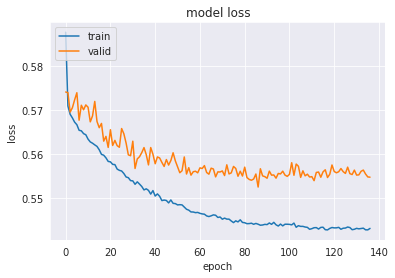

In [20]:
if nas:
    for trial in history: 
        print(trial.summary())
        
    writepath_nas = './results_nas.csv'

    if different_eval_data:
        flat_config = flatten_dict(config_train)
    else:
        flat_config = flatten_dict(config)    

    if not os.path.exists(writepath_nas):
        with open(writepath_nas, 'w+') as text_file:       
            for key in flat_config.keys():
                text_file.write(key)
                text_file.write(';')         

            for hp in history[0].hyperparameters.values.keys():
                text_file.write(hp + ';')    
               
            text_file.write('score')
            
            text_file.write('\n')

    with open(writepath_nas, 'a+') as text_file:  
        for value in flat_config.values():
            text_file.write(str(value))
            text_file.write(';')

        for hp, value in history[0].hyperparameters.values.items():
            text_file.write(str(value) + ';')        

        
        text_file.write(str(history[0].score))
            
        text_file.write('\n')            

        text_file.close()      
        
else:
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')    

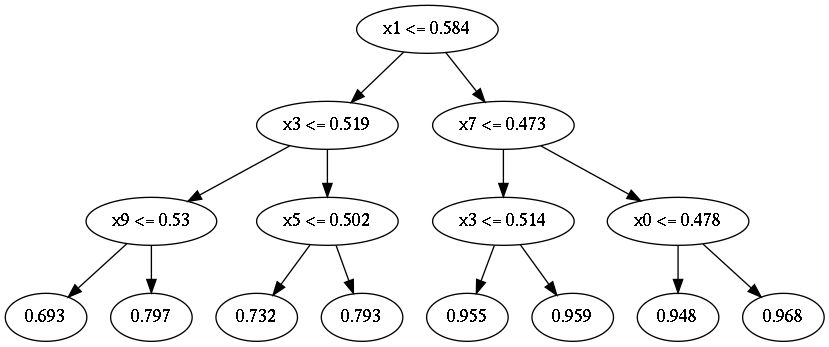

In [21]:
index = 0
if test_size > 0:
    network_parameters = np.array([lambda_net_dataset_test.network_parameters_array[index]])
else:
    network_parameters = np.array([lambda_net_dataset_valid.network_parameters_array[index]])
    
if config['i_net']['data_reshape_version'] == 1 or config['i_net']['data_reshape_version'] == 2:
    network_parameters, network_parameters_flat = restructure_data_cnn_lstm(network_parameters, config, subsequences=None)
elif config['i_net']['data_reshape_version'] == 3: #autoencoder
    network_parameters, network_parameters_flat, _ = autoencode_data(network_parameters, config, encoder_model)    
dt_parameters = model.predict(network_parameters)[0]

if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1537)]       0                                            
__________________________________________________________________________________________________
hidden1_1024 (Dense)            (None, 1024)         1574912     input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 1024)         0           hidden1_1024[0][0]               
__________________________________________________________________________________________________
dropout1_0.3 (Dropout)          (None, 1024)         0           activation1_relu[0][0]           
______________________________________________________________________________________________

    Normal: This is useful for looking at means and other linear combinations (e.g. regression coefficients) because of the CLT. Related to that is if something is known to arise due to additive effects of many different small causes then the normal may be a reasonable distribution: for example, many biological measures are the result of multiple genes and multiple environmental factors and therefor are often approximately normal.

    Gamma: Right skewed and useful for things with a natural minimum at 0. Commonly used for elapsed times and some financial variables.

    Exponential: special case of the Gamma. It is memoryless and scales easily.

    Chi-squared (𝜒2): special case of the Gamma. Arises as sum of squared normal variables (so used for variances).

    Beta: Defined between 0 and 1 (but could be transformed to be between other values), useful for proportions or other quantities that must be between 0 and 1.

    Binomial: How many "successes" out of a given number of independent trials with same probability of "success".

    Poisson: Common for counts. Nice properties that if the number of events in a period of time or area follows a Poisson, then the number in twice the time or area still follows the Poisson (with twice the mean): this works for adding Poissons or scaling with values other than 2.

    Note that if events occur over time and the time between occurrences follows an exponential then the number that occur in a time period follows a Poisson.

    Negative Binomial: Counts with minimum 0 (or other value depending on which version) and no upper bound. Conceptually it is the number of "failures" before k "successes". The negative binomial is also a mixture of Poisson variables whose means come from a gamma distribution.

    Geometric: special case for negative binomial where it is the number of "failures" before the 1st "success". If you truncate (round down) an exponential variable to make it discrete, the result is geometric.

In [23]:

mean_train_parameters = np.round(np.mean(lambda_net_dataset_train.network_parameters_array, axis=0), 5)
std_train_parameters = np.round(np.std(lambda_net_dataset_train.network_parameters_array, axis=0), 5)

(inet_evaluation_result_dict_train, 
 inet_evaluation_result_dict_mean_train, 
 dt_distilled_list_train,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_train.network_parameters_array, 
                                                               lambda_net_dataset_train.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='train',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                               encoder_model=encoder_model)


(inet_evaluation_result_dict_valid, 
 inet_evaluation_result_dict_mean_valid, 
 dt_distilled_list_valid,
 distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_valid.network_parameters_array, 
                                                               lambda_net_dataset_valid.X_test_lambda_array,
                                                               model,
                                                               config,
                                                               identifier='valid',
                                                               mean_train_parameters=mean_train_parameters,
                                                               std_train_parameters=std_train_parameters,
                                                               network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                               distances_dict=distances_dict,
                                                               encoder_model=encoder_model)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:  2.7min
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:  2.9min finished


  0%|          | 0/100 [00:00<?, ?it/s]

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:   17.4s finished


  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
#%load_ext autoreload
#%autoreload 2
#set_loky_pickler('pickle')

In [25]:
config['i_net']['test_size'] = 20

In [26]:
if evaluate_distribution and test_size > 0:
    (distances_dict, 
     inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_complete_by_distribution_test,
     inet_evaluation_result_dict_mean_test,
     inet_evaluation_result_dict_mean_by_distribution_test,
     inet_evaluation_results_test, 
     dt_inet_list_test, 
     dt_distilled_list_test, 
     data_dict_list_test, 
     normalizer_list_list_test,
     test_network_list,
     model_history_list,
     distribution_parameter_list_list) = distribution_evaluation_interpretation_net_synthetic_data(loss_function, 
                                                                                            metrics,
                                                                                            #model,
                                                                                           config,
                                                                                           identifier='test',
                                                                                           lambda_net_parameters_train=lambda_net_dataset_train.network_parameters_array,
                                                                                           mean_train_parameters=mean_train_parameters,
                                                                                           std_train_parameters=std_train_parameters,
                                                                                           distances_dict=distances_dict,
                                                                                           max_distributions_per_class=0,#max_distributions_per_class,
                                                                                           flip_percentage=0.2,
                                                                                           #encoder_model=encoder_model,
                                                                                           distribution_list = ['uniform', 'gamma', 'beta', 'poisson', 'normal', 'binomial', 'exponential'],# #['uniform'],#
                                                                                           random_parameters = False, #random_parameters_distribution
                                                                                           verbose=1,
                                                                                           backend='loky',#sequential
                                                                                    )
else:
    (inet_evaluation_result_dict_test, 
     inet_evaluation_result_dict_mean_test, 
     dt_distilled_list_test,
     distances_dict) = evaluate_interpretation_net_synthetic_data(lambda_net_dataset_test.network_parameters_array, 
                                                                   lambda_net_dataset_test.X_test_lambda_array,
                                                                   model,
                                                                   config,
                                                                   identifier='test',
                                                                   mean_train_parameters=mean_train_parameters,
                                                                   std_train_parameters=std_train_parameters,
                                                                   network_parameters_train_array=lambda_net_dataset_train.network_parameters_array,
                                                                   distances_dict=distances_dict,
                                                                   encoder_model=encoder_model)
    
    print_results_synthetic_evaluation(inet_evaluation_result_dict_mean_train, 
                                       inet_evaluation_result_dict_mean_valid, 
                                       inet_evaluation_result_dict_mean_test, 
                                       distances_dict)    

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:  2.2min remaining: 19.6min
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:  2.2min remaining: 12.4min
[Parallel(n_jobs=20)]: Done   4 out of  20 | elapsed:  2.2min remaining:  8.9min
[Parallel(n_jobs=20)]: Done   5 out of  20 | elapsed:  2.6min remaining:  7.8min
[Parallel(n_jobs=20)]: Done   6 out of  20 | elapsed:  2.6min remaining:  6.2min
[Parallel(n_jobs=20)]: Done   7 out of  20 | elapsed:  2.7min remaining:  5.0min
[Parallel(n_jobs=20)]: Done   8 out of  20 | elapsed:  2.7min remaining:  4.1min
[Parallel(n_jobs=20)]: Done   9 out of  20 | elapsed:  2.8min remaining:  3.4min
[Parallel(n_jobs=20)]: Done  10 out of  20 | elapsed:  2.8min remaining:  2.8min
[Parallel(n_jobs=20)]: Done  11 out of  20 | elapsed:  2.8min remaining:  2.3min
[Parallel(n_jobs=20)]: Done  12 out of  20 | elapse

In [27]:
# generate_dataset_from_distributions

In [28]:
distribution_parameter_list_list[0]

[{'normal': {'loc': 0.5, 'scale': 1}},
 {'poisson': {'lam': 1}},
 {'beta': {'a': 2, 'b': 5}},
 {'uniform': {'low': 0, 'high': 1}},
 {'binomial': {'n': 100, 'p': 0.5}},
 {'normal': {'loc': 0.5, 'scale': 1}},
 {'exponential': {'scale': 0.5}},
 {'poisson': {'lam': 1}},
 {'normal': {'loc': 0.5, 'scale': 1}},
 {'gamma': {'shape': 2, 'scale': 2}}]

In [29]:
distribution_parameter_list_list[1]

[{'binomial': {'n': 100, 'p': 0.5}},
 {'beta': {'a': 2, 'b': 5}},
 {'binomial': {'n': 100, 'p': 0.5}},
 {'binomial': {'n': 100, 'p': 0.5}},
 {'beta': {'a': 2, 'b': 5}},
 {'normal': {'loc': 0.5, 'scale': 1}},
 {'uniform': {'low': 0, 'high': 1}},
 {'binomial': {'n': 100, 'p': 0.5}},
 {'uniform': {'low': 0, 'high': 1}},
 {'binomial': {'n': 100, 'p': 0.5}}]

In [30]:
#np.mean(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy'])

In [31]:
inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']

[0.516,
 0.74,
 0.973,
 0.51,
 0.508,
 0.772,
 0.493,
 0.505,
 0.891,
 0.501,
 0.501,
 0.493,
 0.506,
 0.977,
 0.97,
 0.957,
 0.492,
 0.506,
 0.501,
 0.496]

In [32]:
inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']

[0.558,
 0.987,
 0.977,
 0.907,
 0.773,
 0.85,
 0.497,
 0.91,
 0.943,
 0.501,
 0.501,
 0.93,
 0.551,
 0.56,
 0.632,
 0.771,
 0.492,
 0.505,
 0.511,
 0.968]

In [33]:
print('Median I-Net:', np.median(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['inet_scores']['accuracy']))
print('Median DT Distilled:', np.median(inet_evaluation_result_dict_complete_by_distribution_test['uniform']['dt_scores']['accuracy']))



Median I-Net: 0.507
Median DT Distilled: 0.7015


In [34]:
complete_distribution_evaluation_results = get_complete_distribution_evaluation_results_dataframe(inet_evaluation_result_dict_mean_by_distribution_test)
complete_distribution_evaluation_results.head(20)

,Acc Distilled Train Data,Acc Distilled Data Random,Acc Distilled,Acc I-Net,Soft BC Distilled Train Data,Soft BC Distilled Data Random,Soft BC Distilled,Soft BC I-Net,BC Distilled Train Data,BC Distilled Data Random,BC Distilled,BC I-Net,F1 Score Distilled Train Data,F1 Score Distilled Data Random,F1 Score Distilled,F1 Score I-Net,Runtime Distilled Train Data,Runtime Distilled Data Random,Runtime Distilled,Runtime I-Net
uniform,0.983,0.947,0.716,0.640,0.346,0.373,0.597,0.639,0.109,0.129,1.914,0.612,0.983,0.963,0.798,0.747,0.049,0.049,0.049,0.377
gamma,0.983,0.902,0.696,0.640,0.346,0.421,0.604,0.639,0.111,1.847,2.884,0.612,0.983,0.676,0.525,0.747,0.054,0.054,0.054,0.325
beta,0.983,0.927,0.753,0.640,0.346,0.398,0.544,0.639,0.109,0.177,1.431,0.612,0.983,0.865,0.783,0.747,0.049,0.049,0.049,0.084
poisson,0.983,0.952,0.708,0.640,0.346,0.369,0.580,0.639,0.111,0.118,1.403,0.612,0.983,0.648,0.519,0.747,0.009,0.009,0.009,0.079
normal,0.983,0.975,0.641,0.640,0.346,0.346,0.676,0.639,0.111,0.067,8.337,0.612,0.983,0.983,0.749,0.747,0.026,0.026,0.026,0.076
binomial,0.983,0.972,0.638,0.640,0.346,0.350,0.671,0.639,0.109,0.075,8.369,0.612,0.983,0.981,0.743,0.747,0.007,0.007,0.007,0.068
exponential,0.983,0.880,0.644,0.640,0.346,0.439,0.663,0.639,0.109,3.511,6.188,0.612,0.983,0.681,0.440,0.747,0.037,0.037,0.037,0.066


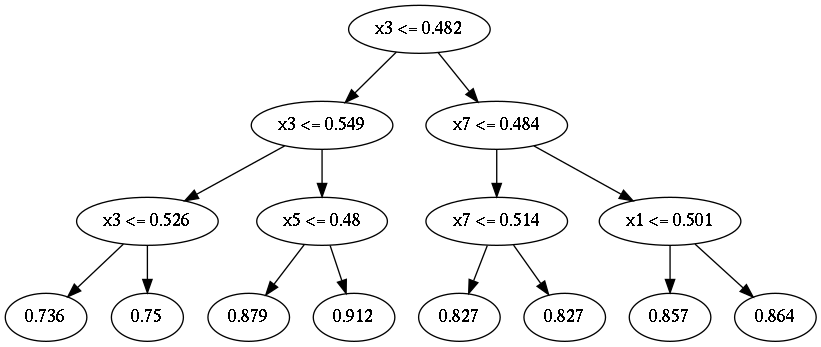

In [35]:
dt_parameters = dt_inet_list_test[0][4]

if config['function_family']['dt_type'] == 'vanilla':
    image, nodes = anytree_decision_tree_from_parameters(dt_parameters, config=config)
else:
    tree = generate_random_decision_tree(config)
    tree.initialize_from_parameter_array(dt_parameters, reshape=True, config=config)
    image = tree.plot_tree()
image

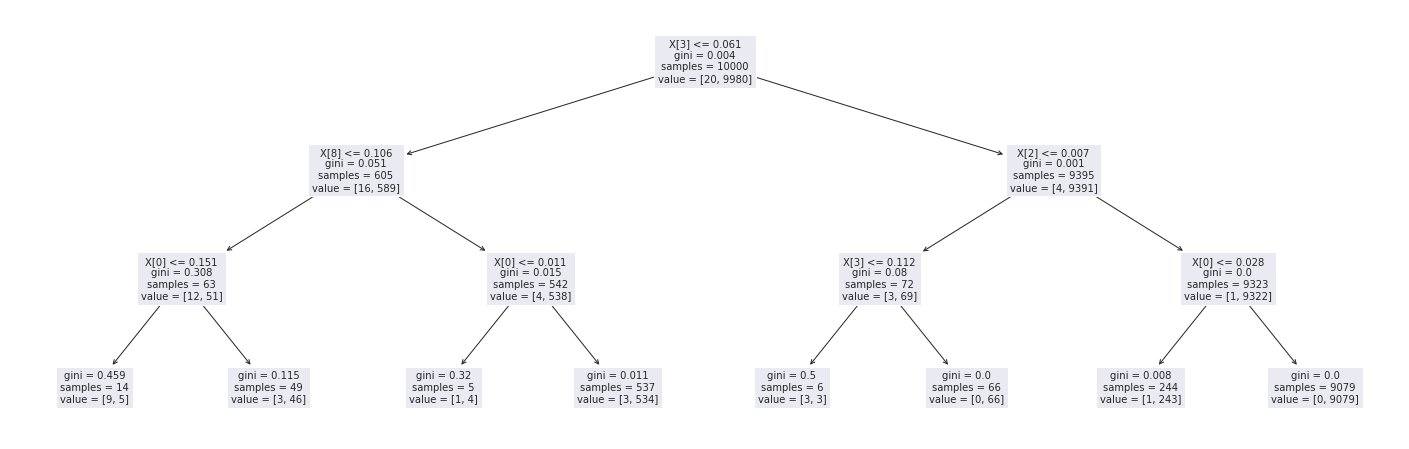

In [36]:
plt.figure(figsize=(25,8))
plot_tree(dt_distilled_list_test[0][4][0], fontsize=10) 
plt.show()

In [37]:
network_distances = get_print_network_distances_dataframe(distances_dict)
network_distances.head(20)

,Average Z-Score (Sample to Train Data),Average Distance to Initialization,Average Mean Distance to Train Data,Average Distance to closest Train Data Sample,Average Biggest Distance for Single Neuron,Minimum Biggest Distance for Single Neuron
train,1159.075,327.325,361.404,0.000,1.598,0.000
valid,1098.419,312.296,349.034,167.018,1.547,0.896
test,1451.604,318.424,391.103,211.025,2.449,1.610


{'uniform': {'class_0': {'low': 0, 'high': 1}, 'class_1': {'low': 0.0, 'high': 1.1579309401710596}}}
{'uniform': {'class_0': {'low': 0, 'high': 1}, 'class_1': {'low': 0.0, 'high': 0.9646864490189441}}}
{'uniform': {'class_0': {'low': 0, 'high': 1}, 'class_1': {'low': 0.0, 'high': 1.0469195434228162}}}
{'uniform': {'class_0': {'low': 0, 'high': 1}, 'class_1': {'low': 0.0, 'high': 0.9651422047317387}}}
{'uniform': {'class_0': {'low': 0, 'high': 1}, 'class_1': {'low': 0.0, 'high': 0.983442823820648}}}
{'uniform': {'class_0': {'low': 0, 'high': 1}, 'class_1': {'low': 0.0, 'high': 0.8726362414034883}}}


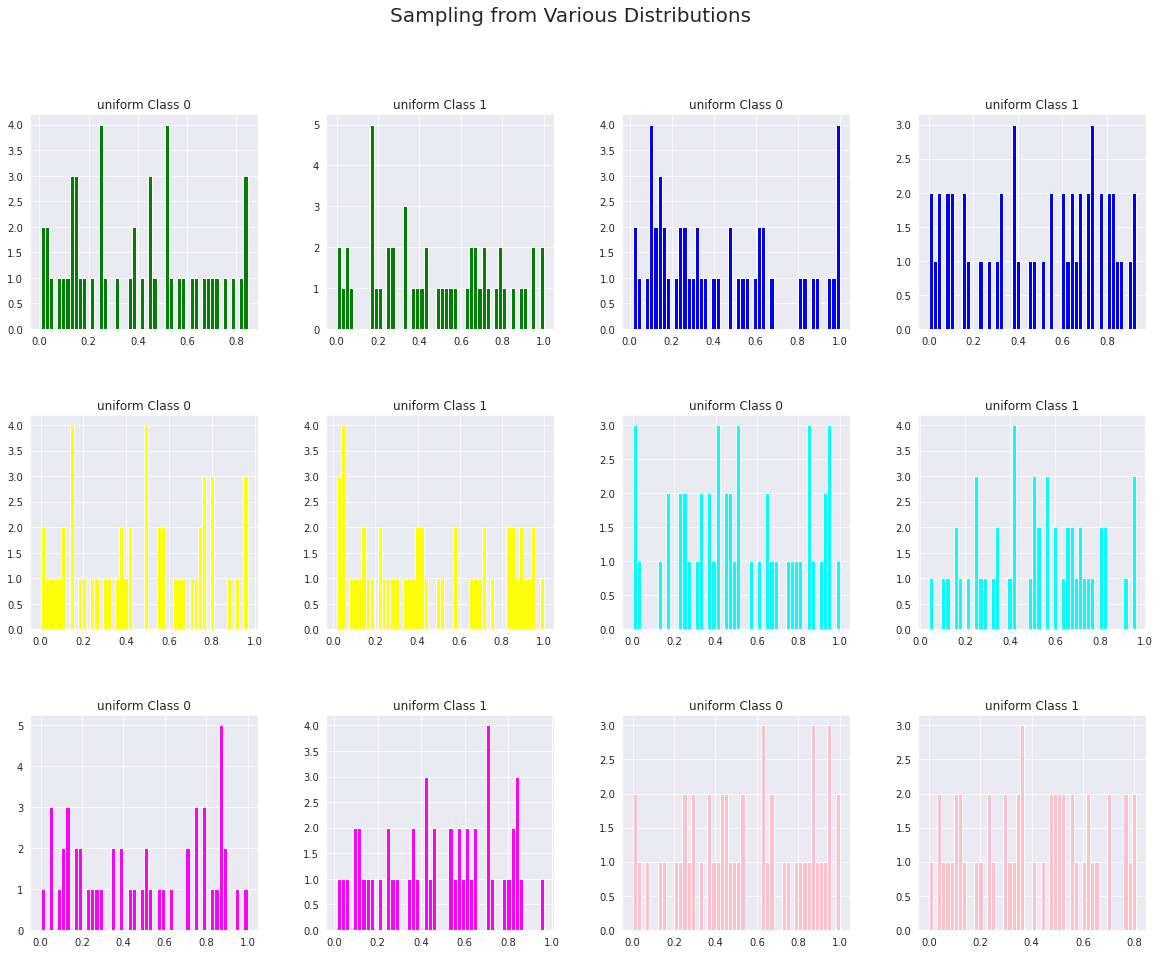

In [38]:
number = 6

X_data, y_data, distribution_parameter_list, normalizer_list = generate_dataset_from_distributions(['uniform'],# ['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'], 
                                      number, 
                                      100,
                                      distributions_per_class = 1, 
                                      seed=41,
                                      flip_percentage=0)

rand = np.random.RandomState(42)    

colors_list = ['green','blue','yellow','cyan','magenta','pink']

fig,ax = plt.subplots(nrows=3, ncols=4,figsize=(20,15))
plot_index = 0

for i,(colors, distribution_parameter) in enumerate(zip(colors_list[:number], distribution_parameter_list[:number])):
    print(distribution_parameter)

    x = X_data[:,i][np.where(y_data==0)]
    plt.subplot(3,4,plot_index+1)
    plt.hist(x,bins=50,color=colors)
    plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
    plot_index += 1
    
    x = X_data[:,i][np.where(y_data==1)]
    plt.subplot(3,4,plot_index+1)
    plt.hist(x,bins=50,color=colors)
    plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
    plot_index += 1
    
fig.subplots_adjust(hspace=0.4,wspace=.3) 
plt.suptitle('Sampling from Various Distributions',fontsize=20)
plt.show()
    

In [39]:
if False:
    test_network = network_parameters_to_network(shaped_network_parameters_to_array(test_network_list[0], config), config, base_model=None)


    X_test = data_dict_list_test[0]['X_test']#generate_random_data_points_custom(config['data']['x_min'], config['data']['x_max'], config['evaluation']['random_evaluation_dataset_size'], config['data']['number_of_variables'], categorical_indices=None, distrib=config['evaluation']['random_evaluation_dataset_distribution'])


    distribution_training = 'uniform'

    evaluation_result_dict, results_list, test_network_parameters, dt_inet, dt_distilled_list = evaluate_network_real_world_data(model,
                                                                                                test_network, 
                                                                                                _, 
                                                                                                X_test, 
                                                                                                dataset_size_list=[10000],
                                                                                                config=config,
                                                                                                distribution=distribution_training)


    results_list_extended = results_list[0]

    #results_list_extended['dt_scores']['soft_binary_crossentropy_train_data'] = results_list[1]['dt_scores']['soft_binary_crossentropy']
    #results_list_extended['dt_scores']['binary_crossentropy_train_data'] = results_list[1]['dt_scores']['binary_crossentropy']
    #results_list_extended['dt_scores']['accuracy_train_data'] = results_list[1]['dt_scores']['accuracy']
    #results_list_extended['dt_scores']['f1_score_train_data'] = results_list[1]['dt_scores']['f1_score']

    results_list = results_list_extended
    evaluation_result_dict = results_list

    test_network_parameters = test_network_parameters#[:1]
    dt_inet = dt_inet#[:1]
    dt_distilled_list = dt_distilled_list#[:1]

    print(evaluation_result_dict)

# REAL DATA EVALUATION

In [40]:
dataset_size_list = [1_000, 10_000, 100_000, 1_000_000, 'TRAIN_DATA']
dataset_size_list_print = []
for size in dataset_size_list:
    if type(size) is int:
        size = size//1000
        size = str(size) + 'k'
        dataset_size_list_print.append(size)
    else:
        dataset_size_list_print.append(size)

In [41]:
#distances_dict = {}
evaluation_result_dict = {}
results_dict = {}
dt_inet_dict = {}
dt_distilled_list_dict = {}
data_dict = {}
normalizer_list_dict = {}

identifier_list = []


## ADULT DATASET

In [42]:
feature_names = [
                 "Age", #0
                 "Workclass",  #1
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Race",  #8
                 "Sex",  #9
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 "Country", #13
                 "capital_gain" #14
                ] 

adult_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', names=feature_names, index_col=False)


#adult_data['Workclass'][adult_data['Workclass'] != ' Private'] = 'Other'
#adult_data['Race'][adult_data['Race'] != ' White'] = 'Other'

#adult_data.head()

features_select = [
                 "Sex",  #9 
                 "Race",  #8
                 "Workclass",  #1
                 "Age", #0
                 "fnlwgt",  #2
                 "Education",  #3
                 "Education-Num",  #4
                 "Marital Status", #5
                 "Occupation",  #6
                 "Relationship",  #7
                 "Capital Gain",  #10
                 "Capital Loss", #11
                 "Hours per week",  #12
                 #"Country", #13 
                 "capital_gain"
                  ]

adult_data = adult_data[features_select]

nominal_features_adult = ['Race', 'Workclass', 'Education', "Marital Status", "Occupation", "Relationship"]
ordinal_features_adult = ['Sex']

X_data_adult = adult_data.drop(['capital_gain'], axis = 1)

#y_data_adult = pd.Series(OrdinalEncoder().fit_transform(adult_data['capital_gain'].values.reshape(-1, 1)).flatten(), name='capital_gain')
y_data_adult = ((adult_data['capital_gain'] != ' <=50K') * 1)

In [43]:
config_train_network_adult = deepcopy(config)
#config_train_network_adult['lambda_net']['batch_lambda'] = 32
#config_train_network_adult['lambda_net']['learning_rate_lambda'] = 0.0003
#config_train_network_adult['lambda_net']['dropout_lambda'] = 0.25
#config_train_network_adult['lambda_net']['epochs_lambda'] = 5

In [44]:
identifier = 'Adult'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_adult, 
                                                                y_data_adult, 
                                                                nominal_features = nominal_features_adult, 
                                                                ordinal_features = ordinal_features_adult,
                                                                config = config,
                                                                config_train_network = config_train_network_adult)

print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict['Adult'], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape:  (32561, 65)


## Titanic Dataset

In [45]:
titanic_data = pd.read_csv("./real_world_datasets/Titanic/train.csv")

titanic_data['Age'].fillna(titanic_data['Age'].mean(), inplace = True)
titanic_data['Fare'].fillna(titanic_data['Fare'].mean(), inplace = True)
    
titanic_data['Embarked'].fillna('S', inplace = True)

features_select = [
                    #'Cabin', 
                    #'Ticket', 
                    #'Name', 
                    #'PassengerId'    
                    'Sex',    
                    'Embarked',
                    'Pclass',
                    'Age',
                    'SibSp',    
                    'Parch',
                    'Fare',    
                    'Survived',    
                  ]

titanic_data = titanic_data[features_select]

nominal_features_titanic = ['Embarked']#[1, 2, 7]
ordinal_features_titanic = ['Sex']
    
X_data_titanic = titanic_data.drop(['Survived'], axis = 1)
y_data_titanic = titanic_data['Survived']


    survival	Survival	0 = No, 1 = Yes
    pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
    sex	Sex	
    Age	Age in years	
    sibsp	# of siblings / spouses aboard the Titanic	
    parch	# of parents / children aboard the Titanic	
    ticket	Ticket number	
    fare	Passenger fare	
    cabin	Cabin number	
    embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [46]:
identifier = 'Titanic'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_titanic, 
                                                                y_data_titanic, 
                                                                nominal_features = nominal_features_titanic, 
                                                                ordinal_features = ordinal_features_titanic,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape:  (891, 9)


## Absenteeism at Work Dataset

In [47]:
absenteeism_data = pd.read_csv('real_world_datasets/Absenteeism/absenteeism.csv', delimiter=';')

features_select = [
                           'Disciplinary failure', #CATEGORICAL
                           'Social drinker', #CATEGORICAL
                           'Social smoker', #CATEGORICAL
                           'Transportation expense', 
                           'Distance from Residence to Work',
                           'Service time', 
                           'Age', 
                           'Work load Average/day ', 
                           'Hit target',
                           'Education', 
                           'Son', 
                           'Pet', 
                           'Weight', 
                           'Height', 
                           'Body mass index', 
                           'Absenteeism time in hours'
                        ]

absenteeism_data = absenteeism_data[features_select]

nominal_features_absenteeism = []
ordinal_features_absenteeism = []
    
X_data_absenteeism = absenteeism_data.drop(['Absenteeism time in hours'], axis = 1)
y_data_absenteeism = ((absenteeism_data['Absenteeism time in hours'] > 4) * 1) #absenteeism_data['Absenteeism time in hours']


    3. Month of absence
    4. Day of the week (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6))
    5. Seasons (summer (1), autumn (2), winter (3), spring (4))
    6. Transportation expense
    7. Distance from Residence to Work (kilometers)
    8. Service time
    9. Age
    10. Work load Average/day
    11. Hit target
    12. Disciplinary failure (yes=1; no=0)
    13. Education (high school (1), graduate (2), postgraduate (3), master and doctor (4))
    14. Son (number of children)
    15. Social drinker (yes=1; no=0)
    16. Social smoker (yes=1; no=0)
    17. Pet (number of pet)
    18. Weight
    19. Height
    20. Body mass index
    21. Absenteeism time in hours (target)

In [48]:
identifier = 'Absenteeism'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_absenteeism, 
                                                                y_data_absenteeism, 
                                                                nominal_features = nominal_features_absenteeism, 
                                                                ordinal_features = ordinal_features_absenteeism,
                                                                config = config,
                                                                config_train_network = None)

print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape:  (740, 15)


# Loan Dataset

In [49]:
loan_data = pd.read_csv('real_world_datasets/Loan/loan-train.csv', delimiter=',')

loan_data['Gender'].fillna(loan_data['Gender'].mode()[0], inplace=True)
loan_data['Dependents'].fillna(loan_data['Dependents'].mode()[0], inplace=True)
loan_data['Married'].fillna(loan_data['Married'].mode()[0], inplace=True)
loan_data['Self_Employed'].fillna(loan_data['Self_Employed'].mode()[0], inplace=True)
loan_data['LoanAmount'].fillna(loan_data['LoanAmount'].mean(), inplace=True)
loan_data['Loan_Amount_Term'].fillna(loan_data['Loan_Amount_Term'].mean(), inplace=True)
loan_data['Credit_History'].fillna(loan_data['Credit_History'].mean(), inplace=True)

features_select = [
                    #'Loan_ID', 
                    'Gender', #
                    'Married', 
                    'Dependents', 
                    'Education',
                    'Self_Employed', 
                    'ApplicantIncome', 
                    'CoapplicantIncome', 
                    'LoanAmount',
                    'Loan_Amount_Term', 
                    'Credit_History', 
                    'Property_Area', 
                    'Loan_Status'
                    ]

loan_data = loan_data[features_select]

nominal_features_loan = [
                        'Dependents',
                        'Education',
                        'Property_Area',    
                        ]
ordinal_features_loan = [
                    'Gender', 
                    'Married', 
                    'Self_Employed',
                   ]
    
X_data_loan = loan_data.drop(['Loan_Status'], axis = 1)
y_data_loan = ((loan_data['Loan_Status'] == 'Y') * 1) #absenteeism_data['Absenteeism time in hours']

In [50]:
identifier = 'Loan House'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_loan, 
                                                                y_data_loan, 
                                                                nominal_features = nominal_features_loan, 
                                                                ordinal_features = ordinal_features_loan,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape:  (614, 17)


# Loan Credit

In [51]:
loan_credit_data = pd.read_csv('real_world_datasets/Credit Loan/train_split.csv', delimiter=',')

loan_credit_data['emp_title'].fillna(loan_credit_data['emp_title'].mode()[0], inplace=True)
loan_credit_data['emp_length'].fillna(loan_credit_data['emp_length'].mode()[0], inplace=True)
#loan_credit_data['desc'].fillna(loan_credit_data['desc'].mode()[0], inplace=True)
loan_credit_data['title'].fillna(loan_credit_data['title'].mode()[0], inplace=True)
#loan_credit_data['mths_since_last_delinq'].fillna(loan_credit_data['mths_since_last_delinq'].mode()[0], inplace=True)
#loan_credit_data['mths_since_last_record'].fillna(loan_credit_data['mths_since_last_record'].mode()[0], inplace=True)
loan_credit_data['revol_util'].fillna(loan_credit_data['revol_util'].mode()[0], inplace=True)
loan_credit_data['collections_12_mths_ex_med'].fillna(loan_credit_data['collections_12_mths_ex_med'].mode()[0], inplace=True)
#loan_credit_data['mths_since_last_major_derog'].fillna(loan_credit_data['mths_since_last_major_derog'].mode()[0], inplace=True)
#loan_credit_data['verification_status_joint'].fillna(loan_credit_data['verification_status_joint'].mode()[0], inplace=True)
loan_credit_data['tot_coll_amt'].fillna(loan_credit_data['tot_coll_amt'].mode()[0], inplace=True)
loan_credit_data['tot_cur_bal'].fillna(loan_credit_data['tot_cur_bal'].mode()[0], inplace=True)
loan_credit_data['total_rev_hi_lim'].fillna(loan_credit_data['total_rev_hi_lim'].mode()[0], inplace=True)


##remove too many null
#'mths_since_last_delinq','mths_since_last_record', 'mths_since_last_major_derog','pymnt_plan','desc', 'verification_status_joint'


features_select = [
                    #'member_id', 
                    'loan_amnt', 
                    'funded_amnt', 
                    'funded_amnt_inv', 
                    'term',
                    #'batch_enrolled',
                    'int_rate', 
                    'grade', 
                    #'sub_grade', 
                    #'emp_title',
                    'emp_length',
                    'home_ownership', 
                    'annual_inc', 
                    'verification_status',
                    #'pymnt_plan', 
                    #'desc', 
                    'purpose', 
                    'title', 
                    #'zip_code', 
                    #'addr_state',
                    'dti', 
                    'delinq_2yrs', 
                    'inq_last_6mths', 
                    #'mths_since_last_delinq',
                    #'mths_since_last_record',
                    'open_acc', 
                    'pub_rec', 
                    'revol_bal',
                    'revol_util', 
                    'total_acc', 
                    'initial_list_status', 
                    'total_rec_int',
                    'total_rec_late_fee', 
                    'recoveries', 
                    'collection_recovery_fee',
                    'collections_12_mths_ex_med', 
                    #'mths_since_last_major_derog',
                    'application_type', 
                    #'verification_status_joint', 
                    'last_week_pay',
                    'acc_now_delinq', 
                    'tot_coll_amt', 
                    'tot_cur_bal', 
                    'total_rev_hi_lim',
                    'loan_status'
                    ]

loan_credit_data = loan_credit_data[features_select]

nominal_features_loan_credit = [

                        ]
ordinal_features_loan_credit = [
                    #'member_id', 
                    'loan_amnt', 
                    'funded_amnt', 
                    'funded_amnt_inv', 
                    'term',
                    #'batch_enrolled',
                    'int_rate', 
                    'grade', 
                    #'sub_grade', 
                    #'emp_title',
                    'emp_length',
                    'home_ownership', 
                    'annual_inc', 
                    'verification_status',
                    #'pymnt_plan', 
                    #'desc', 
                    'purpose', 
                    'title', 
                    #'zip_code', 
                    #'addr_state',
                    'dti', 
                    'delinq_2yrs', 
                    'inq_last_6mths', 
                    #'mths_since_last_delinq',
                    #'mths_since_last_record',
                    'open_acc', 
                    'pub_rec', 
                    'revol_bal',
                    'revol_util', 
                    'total_acc', 
                    'initial_list_status', 
                    'total_rec_int',
                    'total_rec_late_fee', 
                    'recoveries', 
                    'collection_recovery_fee',
                    'collections_12_mths_ex_med', 
                    #'mths_since_last_major_derog',
                    'application_type', 
                    #'verification_status_joint', 
                    'last_week_pay',
                    'acc_now_delinq', 
                    'tot_coll_amt', 
                    'tot_cur_bal', 
                    'total_rev_hi_lim',
                   ]
    
X_data_loan_credit = loan_credit_data.drop(['loan_status'], axis = 1)
y_data_loan_credit = pd.Series(OrdinalEncoder().fit_transform(loan_credit_data['loan_status'].values.reshape(-1, 1)).flatten(), name='loan_status')


In [52]:
identifier = 'Loan Credit'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_loan_credit, 
                                                                y_data_loan_credit, 
                                                                nominal_features = nominal_features_loan_credit, 
                                                                ordinal_features = ordinal_features_loan_credit,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape:  (63999, 32)


# Medical Insurance

In [53]:
medical_insurance_data = pd.read_csv('real_world_datasets/Medical Insurance/insurance.csv', delimiter=',')

features_select = [
                    'age', 
                    'sex', 
                    'bmi', 
                    'children', 
                    'smoker',
                    'region',
                    'charges'
                    ]

medical_insurance_data = medical_insurance_data[features_select]

nominal_features_medical_insurance = [

                        ]
ordinal_features_medical_insurance = [
                    'sex',
                    'region',
                    'smoker'
                   ]

    
X_data_medical_insurance = medical_insurance_data.drop(['charges'], axis = 1)
y_data_medical_insurance = ((medical_insurance_data['charges'] > 10_000) * 1)


print(X_data_medical_insurance.shape)
X_data_medical_insurance.head()


(1338, 6)


,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [54]:
identifier = 'Medical Insurance'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_medical_insurance, 
                                                                y_data_medical_insurance, 
                                                                nominal_features = nominal_features_medical_insurance, 
                                                                ordinal_features = ordinal_features_medical_insurance,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape:  (1338, 6)


# Bank Marketing

In [55]:
bank_data = pd.read_csv('real_world_datasets/Bank Marketing/bank-full.csv', delimiter=';') #bank

features_select = [
                    'age',
                    #'job', 
                    'marital', 
                    'education', 
                    'default',
                    'housing',
                    'loan',
                    #'contact',
                    #'day',
                    #'month',
                    'duration',
                    'campaign',
                    'pdays',
                    'previous',
                    'poutcome',
                    'y',
                    ]

bank_data = bank_data[features_select]

nominal_features_bank = [
                        #'job',
                        'education',
                        #'contact',
                        #'day',
                        #'month',
                        'poutcome',
                        ]
ordinal_features_bank = [
                    'marital',
                    'default',
                    'housing',
                    'loan',
                   ]

    
X_data_bank = bank_data.drop(['y'], axis = 1)
y_data_bank = pd.Series(OrdinalEncoder().fit_transform(bank_data['y'].values.reshape(-1, 1)).flatten(), name='y')


In [56]:
identifier = 'Bank Marketing'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_bank, 
                                                                y_data_bank, 
                                                                nominal_features = nominal_features_bank, 
                                                                ordinal_features = ordinal_features_bank,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape:  (45211, 17)


# Brest Cancer Wisconsin

In [57]:
feature_names = [
                'Sample code number',
                'Clump Thickness',
                'Uniformity of Cell Size',
                'Uniformity of Cell Shape',
                'Marginal Adhesion',
                'Single Epithelial Cell Size',
                'Bare Nuclei',
                'Bland Chromatin',
                'Normal Nucleoli',
                'Mitoses',
                'Class',
                ]

bcw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', names=feature_names, index_col=False)

bcw_data['Clump Thickness'][bcw_data['Clump Thickness'] == '?'] = bcw_data['Clump Thickness'].mode()[0]
bcw_data['Uniformity of Cell Size'][bcw_data['Uniformity of Cell Size'] == '?'] = bcw_data['Uniformity of Cell Size'].mode()[0]
bcw_data['Uniformity of Cell Shape'][bcw_data['Uniformity of Cell Shape'] == '?'] = bcw_data['Uniformity of Cell Shape'].mode()[0]
bcw_data['Marginal Adhesion'][bcw_data['Marginal Adhesion'] == '?'] = bcw_data['Marginal Adhesion'].mode()[0]
bcw_data['Single Epithelial Cell Size'][bcw_data['Single Epithelial Cell Size'] == '?'] = bcw_data['Single Epithelial Cell Size'].mode()[0]
bcw_data['Bare Nuclei'][bcw_data['Bare Nuclei'] == '?'] = bcw_data['Bare Nuclei'].mode()[0]
bcw_data['Bland Chromatin'][bcw_data['Bland Chromatin'] == '?'] = bcw_data['Bland Chromatin'].mode()[0]
bcw_data['Normal Nucleoli'][bcw_data['Normal Nucleoli'] == '?'] = bcw_data['Normal Nucleoli'].mode()[0]
bcw_data['Mitoses'][bcw_data['Mitoses'] == '?'] = bcw_data['Mitoses'].mode()[0]

features_select = [
                #'Sample code number',
                'Clump Thickness',
                'Uniformity of Cell Size',
                'Uniformity of Cell Shape',
                'Marginal Adhesion',
                'Single Epithelial Cell Size',
                'Bare Nuclei',
                'Bland Chromatin',
                'Normal Nucleoli',
                'Mitoses',
                'Class',
                    ]

bcw_data = bcw_data[features_select]

nominal_features_bcw = [
                        ]
ordinal_features_bcw = [
                   ]

    
X_data_bcw = bcw_data.drop(['Class'], axis = 1)
y_data_bcw = pd.Series(OrdinalEncoder().fit_transform(bcw_data['Class'].values.reshape(-1, 1)).flatten(), name='Class')


In [58]:
identifier = 'Brest Cancer Wisconsin'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_bcw, 
                                                                y_data_bcw, 
                                                                nominal_features = nominal_features_bcw, 
                                                                ordinal_features = ordinal_features_bcw,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape:  (699, 9)


# Wisconsin Diagnostic Breast Cancer

In [59]:
feature_names = [
                'ID number',
                'Diagnosis',
                'radius',# (mean of distances from center to points on the perimeter)
                'texture',# (standard deviation of gray-scale values)
                'perimeter',
                'area',
                'smoothness',# (local variation in radius lengths)
                'compactness',# (perimeter^2 / area - 1.0)
                'concavity',# (severity of concave portions of the contour)
                'concave points',# (number of concave portions of the contour)
                'symmetry',
                'fractal dimension',# ("coastline approximation" - 1)
                ]
#Wisconsin Diagnostic Breast Cancer
wdbc_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', names=feature_names, index_col=False)

features_select = [
                    #'ID number',
                    'Diagnosis',
                    'radius',# (mean of distances from center to points on the perimeter)
                    'texture',# (standard deviation of gray-scale values)
                    'perimeter',
                    'area',
                    'smoothness',# (local variation in radius lengths)
                    'compactness',# (perimeter^2 / area - 1.0)
                    'concavity',# (severity of concave portions of the contour)
                    'concave points',# (number of concave portions of the contour)
                    'symmetry',
                    'fractal dimension',# ("coastline approximation" - 1)
                    ]

wdbc_data = wdbc_data[features_select]

nominal_features_wdbc = [
                        ]
ordinal_features_wdbc = [
                   ]

    
X_data_wdbc = wdbc_data.drop(['Diagnosis'], axis = 1)
y_data_wdbc= pd.Series(OrdinalEncoder().fit_transform(wdbc_data['Diagnosis'].values.reshape(-1, 1)).flatten(), name='Diagnosis')


Original Data Shape:  (569, 10)
(343, 10) (343,)
(113, 10) (113,)
(113, 10) (113,)
True Ratio:  0.358600583090379


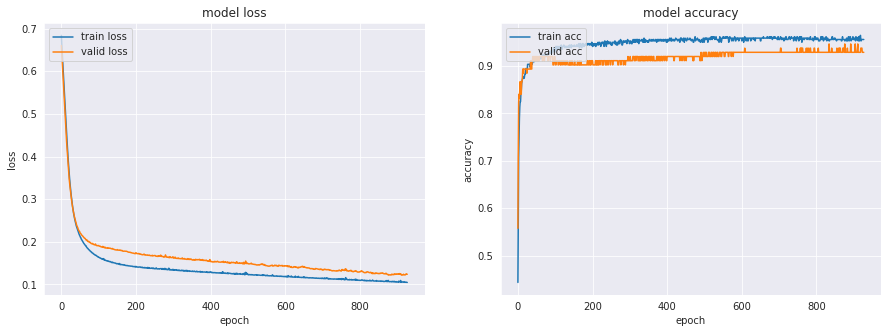

In [60]:
identifier = 'Wisconsin Diagnostic Breast Cancer'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_wdbc, 
                                                                y_data_wdbc, 
                                                                nominal_features = nominal_features_wdbc, 
                                                                ordinal_features = ordinal_features_wdbc,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

# Wisconsin Prognostic Breast Cancer

In [61]:
feature_names = [
                'ID number',
                'Diagnosis',
                'radius',# (mean of distances from center to points on the perimeter)
                'texture',# (standard deviation of gray-scale values)
                'perimeter',
                'area',
                'smoothness',# (local variation in radius lengths)
                'compactness',# (perimeter^2 / area - 1.0)
                'concavity',# (severity of concave portions of the contour)
                'concave points',# (number of concave portions of the contour)
                'symmetry',
                'fractal dimension',# ("coastline approximation" - 1)
                ]
#Wisconsin Prognostic Breast Cancer
wpbc_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wpbc.data', names=feature_names, index_col=False)

features_select = [
                    #'ID number',
                    'Diagnosis',
                    'radius',# (mean of distances from center to points on the perimeter)
                    'texture',# (standard deviation of gray-scale values)
                    'perimeter',
                    'area',
                    'smoothness',# (local variation in radius lengths)
                    'compactness',# (perimeter^2 / area - 1.0)
                    'concavity',# (severity of concave portions of the contour)
                    'concave points',# (number of concave portions of the contour)
                    'symmetry',
                    'fractal dimension',# ("coastline approximation" - 1)
                    ]

wpbc_data = wpbc_data[features_select]

nominal_features_wpbc = [
                        ]
ordinal_features_wpbc = [
                   ]
 
X_data_wpbc = wpbc_data.drop(['Diagnosis'], axis = 1)
y_data_wpbc= pd.Series(OrdinalEncoder().fit_transform(wpbc_data['Diagnosis'].values.reshape(-1, 1)).flatten(), name='Diagnosis')


Original Data Shape:  (198, 10)
(120, 10) (120,)
(39, 10) (39,)
(39, 10) (39,)
True Ratio:  0.24166666666666667
True Ratio:  0.5


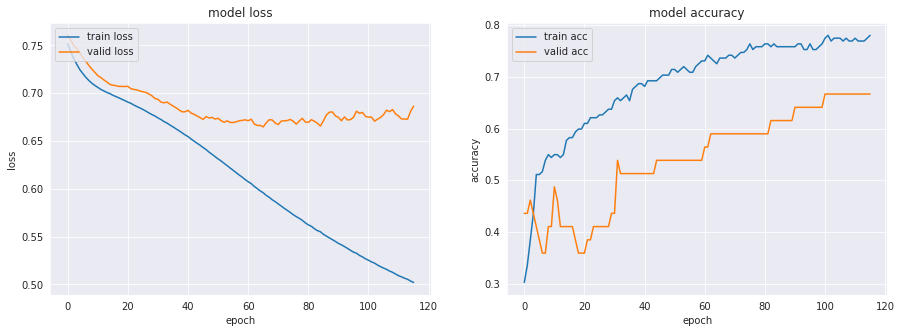

In [62]:
identifier = 'Wisconsin Prognostic Breast Cancer'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_wpbc, 
                                                                y_data_wpbc, 
                                                                nominal_features = nominal_features_wpbc, 
                                                                ordinal_features = ordinal_features_wpbc,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

# Abalone

In [63]:
feature_names = [
                'Sex',#		nominal			M, F, and I (infant)
                'Length',#	continuous	mm	Longest shell measurement
                'Diameter',#	continuous	mm	perpendicular to length
                'Height',#		continuous	mm	with meat in shell
                'Whole weight',#	continuous	grams	whole abalone
                'Shucked weight',#	continuous	grams	weight of meat
                'Viscera weight',#	continuous	grams	gut weight (after bleeding)
                'Shell weight',#	continuous	grams	after being dried
                'Rings',#		integer			+1.5 gives the age in years
                ]

abalone_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', names=feature_names, index_col=False)


features_select = [
                'Sex',#		nominal			M, F, and I (infant)
                'Length',#	continuous	mm	Longest shell measurement
                'Diameter',#	continuous	mm	perpendicular to length
                'Height',#		continuous	mm	with meat in shell
                'Whole weight',#	continuous	grams	whole abalone
                'Shucked weight',#	continuous	grams	weight of meat
                'Viscera weight',#	continuous	grams	gut weight (after bleeding)
                'Shell weight',#	continuous	grams	after being dried
                'Rings',#		integer			+1.5 gives the age in years
                    ]

abalone_data = abalone_data[features_select]

nominal_features_abalone = [
                        'Sex',
                        ]
ordinal_features_abalone = [
                   ]
   
X_data_abalone = abalone_data.drop(['Rings'], axis = 1)
y_data_abalone = ((abalone_data['Rings'] > 10) * 1)
    

Original Data Shape:  (4177, 10)
(2507, 10) (2507,)
(835, 10) (835,)
(835, 10) (835,)
True Ratio:  0.3494216194654966


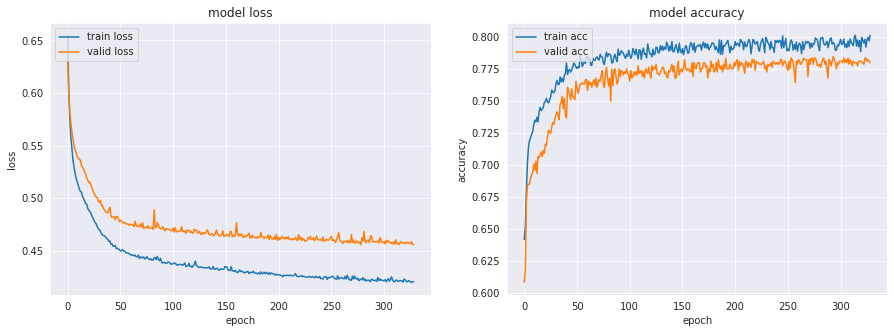

In [64]:
identifier = 'Abalone'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_abalone, 
                                                                y_data_abalone, 
                                                                nominal_features = nominal_features_abalone, 
                                                                ordinal_features = ordinal_features_abalone,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

# Car

In [65]:
feature_names = [
   'buying',#       v-high, high, med, low
   'maint',#        v-high, high, med, low
   'doors',#        2, 3, 4, 5-more
   'persons',#      2, 4, more
   'lug_boot',#     small, med, big
   'safety',#       low, med, high
   'class',#        unacc, acc, good, v-good
                ]

car_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', names=feature_names, index_col=False)

features_select = [
                   'buying',#       v-high, high, med, low
                   'maint',#        v-high, high, med, low
                   'doors',#        2, 3, 4, 5-more
                   'persons',#      2, 4, more
                   'lug_boot',#     small, med, big
                   'safety',#       low, med, high
                   'class',#        unacc, acc, good, v-good
                    ]

car_data = car_data[features_select]

nominal_features_car = [
                       'buying',#       v-high, high, med, low
                       'maint',#        v-high, high, med, low
                       'doors',#        2, 3, 4, 5-more
                       'persons',#      2, 4, more
                       'lug_boot',#     small, med, big
                       'safety',#       low, med, high
                        ]

ordinal_features_car = [
                   ]


    
X_data_car = car_data.drop(['class'], axis = 1)
y_data_car = ((car_data['class'] != 'unacc') * 1)

In [66]:
identifier = 'Car'
identifier_list.append(identifier)

(distances_dict[identifier], 
 evaluation_result_dict[identifier], 
 results_dict[identifier], 
 dt_inet_dict[identifier], 
 dt_distilled_list_dict[identifier], 
 data_dict[identifier],
 normalizer_list_dict[identifier]) = evaluate_real_world_dataset(model,
                                                                dataset_size_list,
                                                                mean_train_parameters,
                                                                std_train_parameters,
                                                                lambda_net_dataset_train.network_parameters_array,
                                                                X_data_car, 
                                                                y_data_car, 
                                                                nominal_features = nominal_features_car, 
                                                                ordinal_features = ordinal_features_car,
                                                                config = config,
                                                                config_train_network = None)
print_head = None
if verbosity > 0:
    print_results_different_data_sizes(results_dict[identifier], dataset_size_list_print)
    print_network_distances(distances_dict)

    dt_inet_plot = plot_decision_tree_from_parameters(dt_inet_dict[identifier], normalizer_list_dict[identifier], config)
    dt_distilled_plot = plot_decision_tree_from_model(dt_distilled_list_dict[identifier][-2], config)

    display(dt_inet_plot, dt_distilled_plot)

    print_head = data_dict[identifier]['X_train'].head()
print_head

Original Data Shape:  (1728, 21)


# Plot and Save Results

In [67]:
#print_complete_performance_evaluation_results(results_dict, identifier_list, dataset_size_list, dataset_size=10000)
complete_performance_evaluation_results = get_complete_performance_evaluation_results_dataframe(results_dict, 
                                                                                                identifier_list, 
                                                                                                dataset_size_list,
                                                                                                dataset_size=10000)
complete_performance_evaluation_results.head(20)

,Acc Distilled,Acc I-Net,Soft BC Distilled,Soft BC I-Net,BC Distilled,BC I-Net,F1 Score Distilled,F1 Score I-Net,Runtime Distilled,Runtime I-Net
Adult,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Titanic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Absenteeism,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Loan House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Loan Credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medical Insurance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bank Marketing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brest Cancer Wisconsin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wisconsin Diagnostic Breast Cancer,0.372,0.690,0.729,0.655,0.838,0.621,0.542,0.314,0.033,0.072
Wisconsin Prognostic Breast Cancer,0.744,0.692,0.610,0.670,0.365,0.638,0.500,0.571,0.033,0.064


In [68]:
complete_distribution_evaluation_results = get_complete_distribution_evaluation_results_dataframe(inet_evaluation_result_dict_mean_by_distribution_test)
complete_distribution_evaluation_results.head(20)

,Acc Distilled Train Data,Acc Distilled Data Random,Acc Distilled,Acc I-Net,Soft BC Distilled Train Data,Soft BC Distilled Data Random,Soft BC Distilled,Soft BC I-Net,BC Distilled Train Data,BC Distilled Data Random,BC Distilled,BC I-Net,F1 Score Distilled Train Data,F1 Score Distilled Data Random,F1 Score Distilled,F1 Score I-Net,Runtime Distilled Train Data,Runtime Distilled Data Random,Runtime Distilled,Runtime I-Net
uniform,0.983,0.947,0.716,0.640,0.346,0.373,0.597,0.639,0.109,0.129,1.914,0.612,0.983,0.963,0.798,0.747,0.049,0.049,0.049,0.377
gamma,0.983,0.902,0.696,0.640,0.346,0.421,0.604,0.639,0.111,1.847,2.884,0.612,0.983,0.676,0.525,0.747,0.054,0.054,0.054,0.325
beta,0.983,0.927,0.753,0.640,0.346,0.398,0.544,0.639,0.109,0.177,1.431,0.612,0.983,0.865,0.783,0.747,0.049,0.049,0.049,0.084
poisson,0.983,0.952,0.708,0.640,0.346,0.369,0.580,0.639,0.111,0.118,1.403,0.612,0.983,0.648,0.519,0.747,0.009,0.009,0.009,0.079
normal,0.983,0.975,0.641,0.640,0.346,0.346,0.676,0.639,0.111,0.067,8.337,0.612,0.983,0.983,0.749,0.747,0.026,0.026,0.026,0.076
binomial,0.983,0.972,0.638,0.640,0.346,0.350,0.671,0.639,0.109,0.075,8.369,0.612,0.983,0.981,0.743,0.747,0.007,0.007,0.007,0.068
exponential,0.983,0.880,0.644,0.640,0.346,0.439,0.663,0.639,0.109,3.511,6.188,0.612,0.983,0.681,0.440,0.747,0.037,0.037,0.037,0.066


In [69]:
#print_network_distances(distances_dict)
network_distances = get_print_network_distances_dataframe(distances_dict)
network_distances.head(20)

,Average Z-Score (Sample to Train Data),Average Distance to Initialization,Average Mean Distance to Train Data,Average Distance to closest Train Data Sample,Average Biggest Distance for Single Neuron,Minimum Biggest Distance for Single Neuron
train,1159.075,327.325,361.404,0.000,1.598,0.000
valid,1098.419,312.296,349.034,167.018,1.547,0.896
test,1451.604,318.424,391.103,211.025,2.449,1.610
Adult,NaN,NaN,NaN,NaN,NaN,NaN
Titanic,NaN,NaN,NaN,NaN,NaN,NaN
Absenteeism,NaN,NaN,NaN,NaN,NaN,NaN
Loan House,NaN,NaN,NaN,NaN,NaN,NaN
Loan Credit,NaN,NaN,NaN,NaN,NaN,NaN
Medical Insurance,NaN,NaN,NaN,NaN,NaN,NaN
Bank Marketing,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
z

NameError: name 'z' is not defined

In [ ]:
writepath_complete = './results_complete.csv'
writepath_summary = './results_summary.csv'

#TODO: ADD COMPLEXITY FOR DTS

if different_eval_data:
    flat_config = flatten_dict(config_train)
else:
    flat_config = flatten_dict(config)    

flat_dict_train = flatten_dict(inet_evaluation_result_dict_train)
flat_dict_valid = flatten_dict(inet_evaluation_result_dict_valid)
if not evaluate_distribution:
    flat_dict_test = flatten_dict(inet_evaluation_result_dict_test)
else:
    flat_dict_test = flatten_dict(inet_evaluation_result_dict_complete_by_distribution_test)

if not os.path.exists(writepath_complete):
    with open(writepath_complete, 'w+') as text_file:       
        for key in flat_config.keys():
            text_file.write(key)
            text_file.write(';')      
        
        number_of_evaluated_networks = np.array(flat_dict_train['inet_scores_binary_crossentropy']).shape[0]
        for key in flat_dict_train.keys():
            #if 'function_values' not in key:
            for i in range(number_of_evaluated_networks):
                text_file.write(key + '_train_' + str(i) + ';')    
                    
        number_of_evaluated_networks = np.array(flat_dict_valid['inet_scores_binary_crossentropy']).shape[0]
        for key in flat_dict_valid.keys():
            #if 'function_values' not in key:
            for i in range(number_of_evaluated_networks):
                text_file.write(key + '_valid_' + str(i) + ';')       
                
        number_of_evaluated_networks = np.array(flat_dict_test[list(flat_dict_test.keys())[0]]).shape[0]
        for key in flat_dict_test.keys():
            #if 'function_values' not in key:
            for i in range(number_of_evaluated_networks):
                text_file.write(key + '_test_' + str(i) + ';')          
        
        text_file.write('\n')
    
with open(writepath_complete, 'a+') as text_file:  
    for value in flat_config.values():
        text_file.write(str(value))
        text_file.write(';')
            
        
    number_of_evaluated_networks = np.array(flat_dict_train['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_train.items():
        #if 'function_values' not in key:
        for score in values:
            text_file.write(str(score) + ';')   

    number_of_evaluated_networks = np.array(flat_dict_valid['inet_scores_binary_crossentropy']).shape[0]
    for key, values in flat_dict_valid.items():
        #if 'function_values' not in key:
        for score in values:
            text_file.write(str(score) + ';')   

    number_of_evaluated_networks = np.array(flat_dict_test[list(flat_dict_test.keys())[0]]).shape[0]
    for key, values in flat_dict_test.items():
        #if 'function_values' not in key:
        for score in values:
            text_file.write(str(score) + ';')   
                    
    text_file.write('\n')            

    text_file.close()  
    


In [ ]:
inet_evaluation_result_dict_mean_train_flat = flatten_dict(inet_evaluation_result_dict_mean_train)
inet_evaluation_result_dict_mean_valid_flat = flatten_dict(inet_evaluation_result_dict_mean_valid)
if not evaluate_distribution:
    inet_evaluation_result_dict_mean_test_flat = flatten_dict(inet_evaluation_result_dict_mean_test)
else:
    inet_evaluation_result_dict_mean_test_flat = flatten_dict(inet_evaluation_result_dict_mean_by_distribution_test)

#identifier_list_synthetic = ['train', 'valid', 'test']
identifier_list_combined = list(flatten_list([identifier_list_synthetic, ['train', 'valid', 'test']]))

if not os.path.exists(writepath_summary):
    with open(writepath_summary, 'w+') as text_file: 
            
        for key in flat_config.keys():
            text_file.write(key + ';')
         
        for key in inet_evaluation_result_dict_mean_train_flat.keys():
            text_file.write('train_' + key + ';')
        for key in inet_evaluation_result_dict_mean_valid_flat.keys():
            text_file.write('valid_' + key + ';')            
        for key in inet_evaluation_result_dict_mean_test_flat.keys():
            text_file.write('test_' + key + ';')                
        
        for dataset_size in dataset_size_list:
            for identifier in identifier_list:
                results_dict_flat = flatten_dict(results_dict[identifier][-2])
                #del results_dict_flat['function_values_y_test_inet_dt']
                #del results_dict_flat['function_values_y_test_distilled_dt']

                for key in results_dict_flat.keys():
                    text_file.write(key + '_' + identifier + '_' + str(dataset_size) + ';')                                   
         

        for key in distances_dict['train'].keys():
            for identifier in identifier_list_combined:
                text_file.write(key + '_' + identifier + ';') 
        
        text_file.write('\n')
    
with open(writepath_summary, 'a+') as text_file: 
    
    for value in flat_config.values():
        text_file.write(str(value) + ';')
        
    for value in inet_evaluation_result_dict_mean_train_flat.values():
        text_file.write(str(value) + ';')
    for value in inet_evaluation_result_dict_mean_valid_flat.values():
        text_file.write(str(value) + ';')            
    for value in inet_evaluation_result_dict_mean_test_flat.values():
        text_file.write(str(value) + ';')

    for i in range(len(dataset_size_list)):
        for identifier in identifier_list:
            evaluation_result_dict_flat = flatten_dict(evaluation_result_dict[identifier])
            #del evaluation_result_dict_flat['function_values_y_test_inet_dt']
            #del evaluation_result_dict_flat['function_values_y_test_distilled_dt']
            
            for values in evaluation_result_dict_flat.values():
                text_file.write(str(values) + ';')    #values[i]        
     
    for key in distances_dict['train'].keys():
        for identifier in identifier_list_combined:
            text_file.write(str(distances_dict[identifier][key]) + ';')      
    
    text_file.write('\n')

    text_file.close()      

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)
Figure(1500x500)


## NEXT DATASET